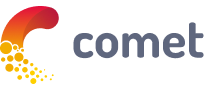

Data science and machine learning teams use [Comet](https://comet.com/?utm_source=website&utm_medium=referral&utm_campaign=Online_CV_2023&utm_content=colab-notebook)’s ML platform to track, compare, explain, and optimize their models across the complete ML lifecycle – from managing experiments to monitoring models in production.

Comet works with Jupyter Notebooks and Scripts and most importantly it is 100% free to [get started](https://www.comet.com/signup?utm_source=website&utm_medium=referral&utm_campaign=Online_CV_2023&utm_content=colab-notebook)!

-----

**To find out more about Comet, please visit our [documentation page](https://www.comet.com/docs/v2/?utm_source=website&utm_medium=referral&utm_campaign=Online_CV_2023&utm_content=colab-notebook)** 

In this guide, we will walkthrough some of the tools available in Comet's Experiment Management product that can help you effectively train and debug Computer Vision models. 

We are going to build a simple image classification model using the [SVHN dataset](https://huggingface.co/datasets/svhn), and
track our training metrics and parameters with Comet.  

After we log the data, we will take a look at some of the [Built In and Custom Panels](https://www.comet.com/docs/v2/guides/comet-dashboard/code-panels/about-panels/?utm_source=website&utm_medium=referral&utm_campaign=Online_CV_2023&utm_content=colab-notebook) that can be used to visualize our training run and debug model predictions.    

**Note**: If you would like to skip the model training and evaluation steps, head over to the ["Debugging Vision Models with Comet"](#scrollTo=DE9NHp7Ga7bh) section to view a completed project and see the ways in which you can leverage Comet to surface model insights. 

**Let's get started!** 🚀

# 🔧 Install Comet and Other Dependencies

In [ ]:
%pip install comet_ml torch torchvision timm datasets h5py scipy scikit-learn "pandas<2"

# 💥 Initialize Comet and create an Experiment

Create your free account Comet Account [here](https://www.comet.com/signup?utm_source=website&utm_medium=referral&utm_campaign=Online_CV_2023&utm_content=colab-notebook) and grab your API Key from the account settings page. 

In [ ]:
import comet_ml

comet_ml.init(project_name="comet-example-pytorch-image-classification-svhn")

# Create the Comet Experiment for logging
experiment = comet_ml.Experiment()

# 🖼️ Load the Vision Dataset

For the purpose of this guide, we will only use a small subset of the SVHN dataset to build our training and test datasets. 

We will sample **1000** examples from the training split and **100** examples from the test split. 

In [ ]:
import torch
import random
import torchvision.transforms as T
from datasets import load_dataset
from torch.utils.data import DataLoader

# Set the batch size for training
BATCH_SIZE = 32

# Sample 1000 examples from the training split as our training set
NUM_TRAIN_SAMPLES = 1000
train_dataset = load_dataset("svhn", "cropped_digits", split="train", streaming=True)
train_dataset = train_dataset.take(NUM_TRAIN_SAMPLES)

# Sample 100 examples from the training split as our test set
NUM_TEST_SAMPLES = 100
test_dataset = load_dataset("svhn", "cropped_digits", split="test", streaming=True)
test_dataset = test_dataset.take(NUM_TEST_SAMPLES)

transforms = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


def collate_fn(examples):
    pixel_values = torch.stack([transforms(example["image"]) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=False,
)

# 🤖 Define the Model and Training Parameters

In [ ]:
import timm

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "resnet18"
EPOCHS = 5

model = timm.create_model(MODEL_NAME, num_classes=10, pretrained=True)
model = model.to(device)

optimizer = AdamW(model.parameters())
cross_entropy = CrossEntropyLoss()

# ⚙️ Log Experiment Parameters

In [ ]:
# Log Training Parameters
experiment.log_parameters(
    {"model_name": MODEL_NAME, "batch_size": BATCH_SIZE, "epochs": EPOCHS}
)
# Log Optimizer Parameters
experiment.log_parameters(optimizer.defaults, prefix="optimizer")

# 📉 Train the Model

In [ ]:
from tqdm import tqdm
from comet_ml.integration.pytorch import log_model

model.train()

# Context manager will automatically append the `train_` prefix to all reported metrics
with experiment.train():
    for epoch in tqdm(range(EPOCHS)):
        total_loss = 0
        correct = 0

        for idx, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            images = batch["pixel_values"]
            labels = batch["labels"]

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = cross_entropy(logits, labels)

            pred = logits.argmax(dim=1, keepdim=True)

            # Compute train accuracy
            batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            batch_total = labels.size(0)

            total_loss += loss.item()
            correct += batch_correct

            # Log batch level metrics to Comet at every step
            experiment.log_metrics(
                {
                    "batch_accuracy": batch_correct / batch_total,
                    "batch_loss": loss.item(),
                }
            )

            loss.backward()
            optimizer.step()

        total_loss /= NUM_TRAIN_SAMPLES
        correct /= NUM_TRAIN_SAMPLES

        # Log the epoch level metrics to Comet
        experiment.log_metrics({"accuracy": correct, "loss": total_loss}, epoch=epoch)

# Save the model
log_model(experiment, model, "svhn-classifier")

# 📊 Evaluate the Model

Now that we have trained our model, lets move on to evaluating its predictions. 

We are going to use a Pandas Dataframe to save some metadata about our predictions that we can then use for analysis. 

We will use the Dataframe to keep track of the Image Id, ground truth label, predictions and cross entropy loss value for each test set example.   

Additionally, we will also log the images from our test set to Comet, so that we can identify the types of images that the model might be struggling with.  

In [ ]:
import pandas as pd

evaluation_df = pd.DataFrame()
image_asset_metadata = []

model.eval()

for idx, example in enumerate(test_dataset):
    image_id = f"test_{idx}"

    # Log the Image to Comet
    asset_metadata = experiment.log_image(example["image"], image_id)

    # Keep track of the image asset metadata returned from the logging step
    image_asset_metadata.append(asset_metadata)

    image = transforms(example["image"])
    image = image.to(device)
    label = torch.tensor(example["label"]).to(device)

    with torch.no_grad():
        logits = model(image.unsqueeze(0))

    loss = cross_entropy(logits, label.unsqueeze(0))
    pred = logits.argmax(dim=1, keepdim=True)

    evaluation_df = evaluation_df.append(
        {
            "image_id": image_id,
            "cross_entropy_loss": loss.item(),
            "predictions": pred.item(),
            "labels": example["label"],
        },
        ignore_index=True,
    )

# Log the dataframe as a table to Comet
experiment.log_table("evaluation.csv", evaluation_df)

### ❓ Log a Confusion Matrix

Classifcation problems become much easier to debug when you use a Confusion Matrix. 

Comet's interactive Confusion Matrix makes it easy to not only understand which classes are being misclassified, but also displays the exact image samples that have been misclassified.  

In [ ]:
from sklearn.metrics import accuracy_score


def fetch_image_asset(idx):
    return {"sample": f"test_{idx}", "assetId": image_asset_metadata[idx]["imageId"]}


predictions = evaluation_df["predictions"].astype(int).tolist()
labels = evaluation_df["labels"].astype(int).tolist()

# Log a Confusion Matrix to evaluate Model Predictions
experiment.log_confusion_matrix(
    labels, predictions, index_to_example_function=fetch_image_asset
)

with experiment.test():
    accuracy = accuracy_score(labels, predictions)
    loss = evaluation_df["cross_entropy_loss"].mean()

    experiment.log_metrics({"accuracy": accuracy, "loss": loss})

# 🏁 End the Experiment

Finally, let's wrap up our experiment and close the conneciton to Comet. 

In [ ]:
experiment.end()

# 🪲 Debugging Vision Models with Comet

## 📋 Getting an Overview of what was attempted

Comet Projects allows you [to create custom views](https://www.comet.com/docs/v2/guides/comet-dashboard/sharing-your-work/#dashboard-views?utm_source=website&utm_medium=referral&utm_campaign=Online_CV_2023&utm_content=colab-notebook) that provide different types of context for the problem you are trying to solve. 

Here is an Overview to help us understand what has been attempted to solve our Image Classification problem, and displays the latest status of our evaluation metrics



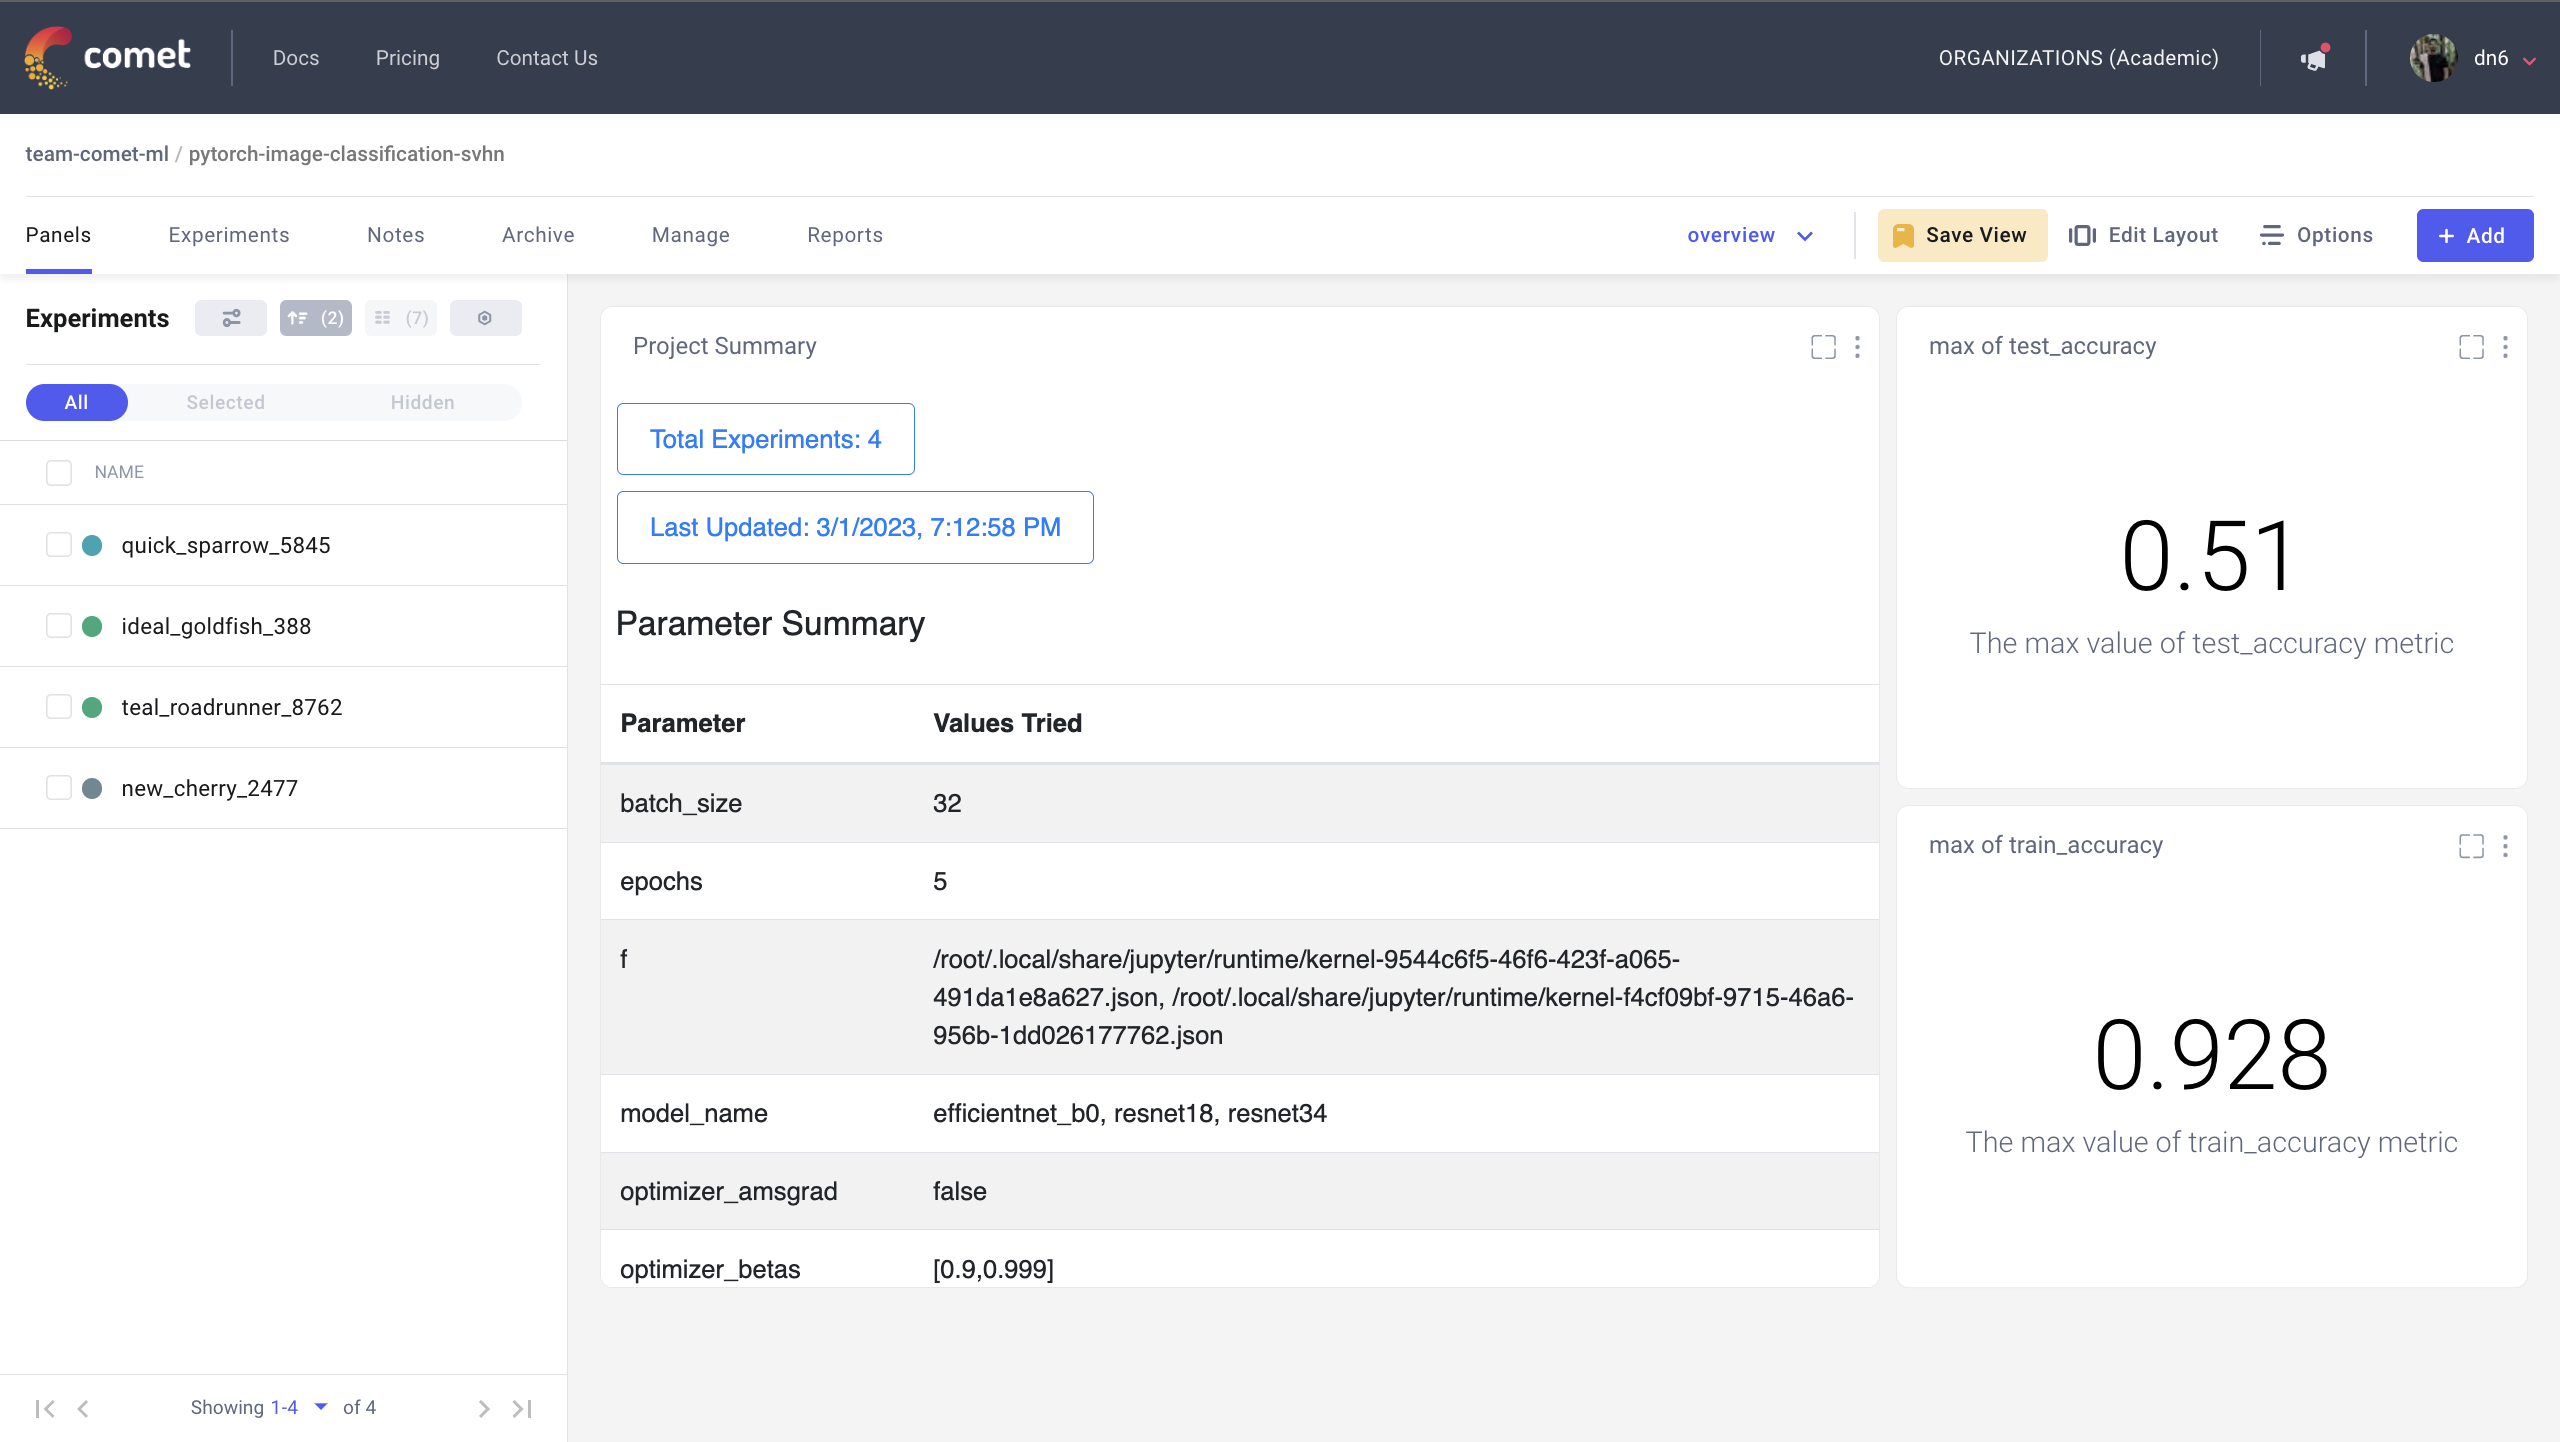

## 🧮 Visualizing Metrics

The next view we are going to build visualizes our model's training metrics and the hyperparameters that led to our results.

We can use the parallel coordinates chart to get an overview of the relevant hyperparameters and how they correlate to our test accuracy. 

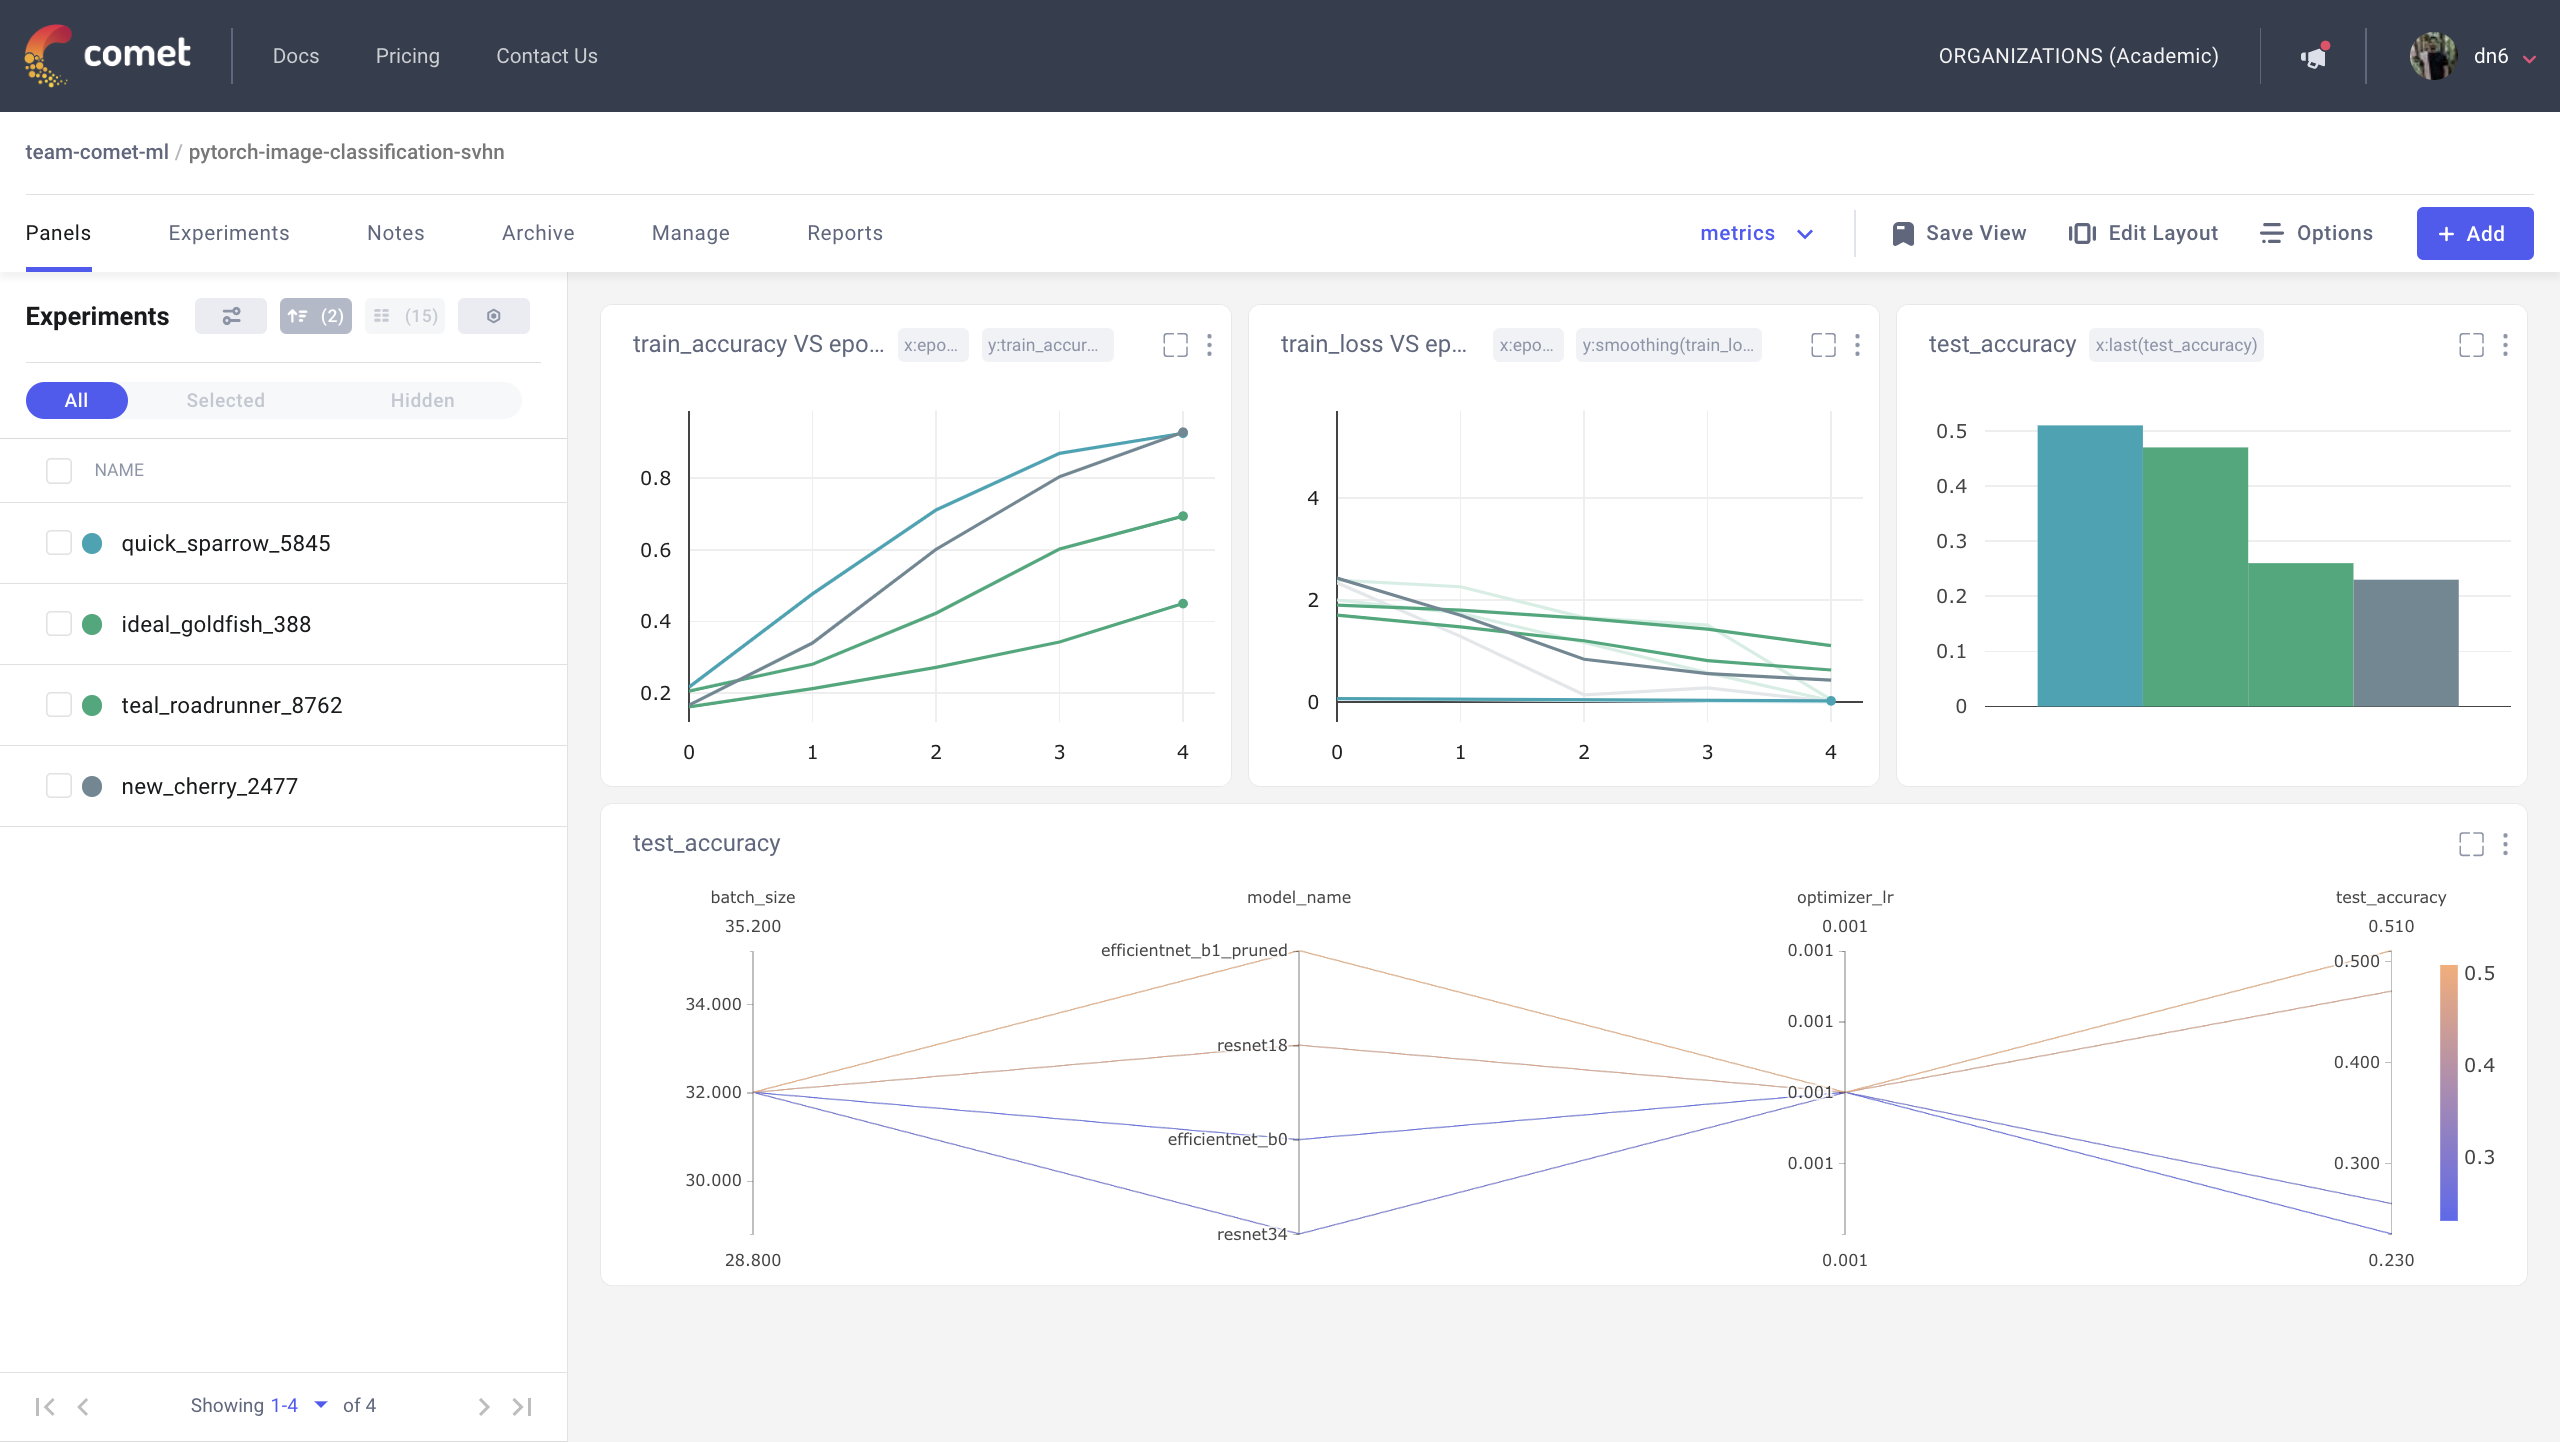

## 🔬 Drilling down with the Confusion Matrix

Let's take a look at the quality of our model predictions. The Confusion Matrix that we logged earlier should give us a good idea of the types of mistakes our model is making. 

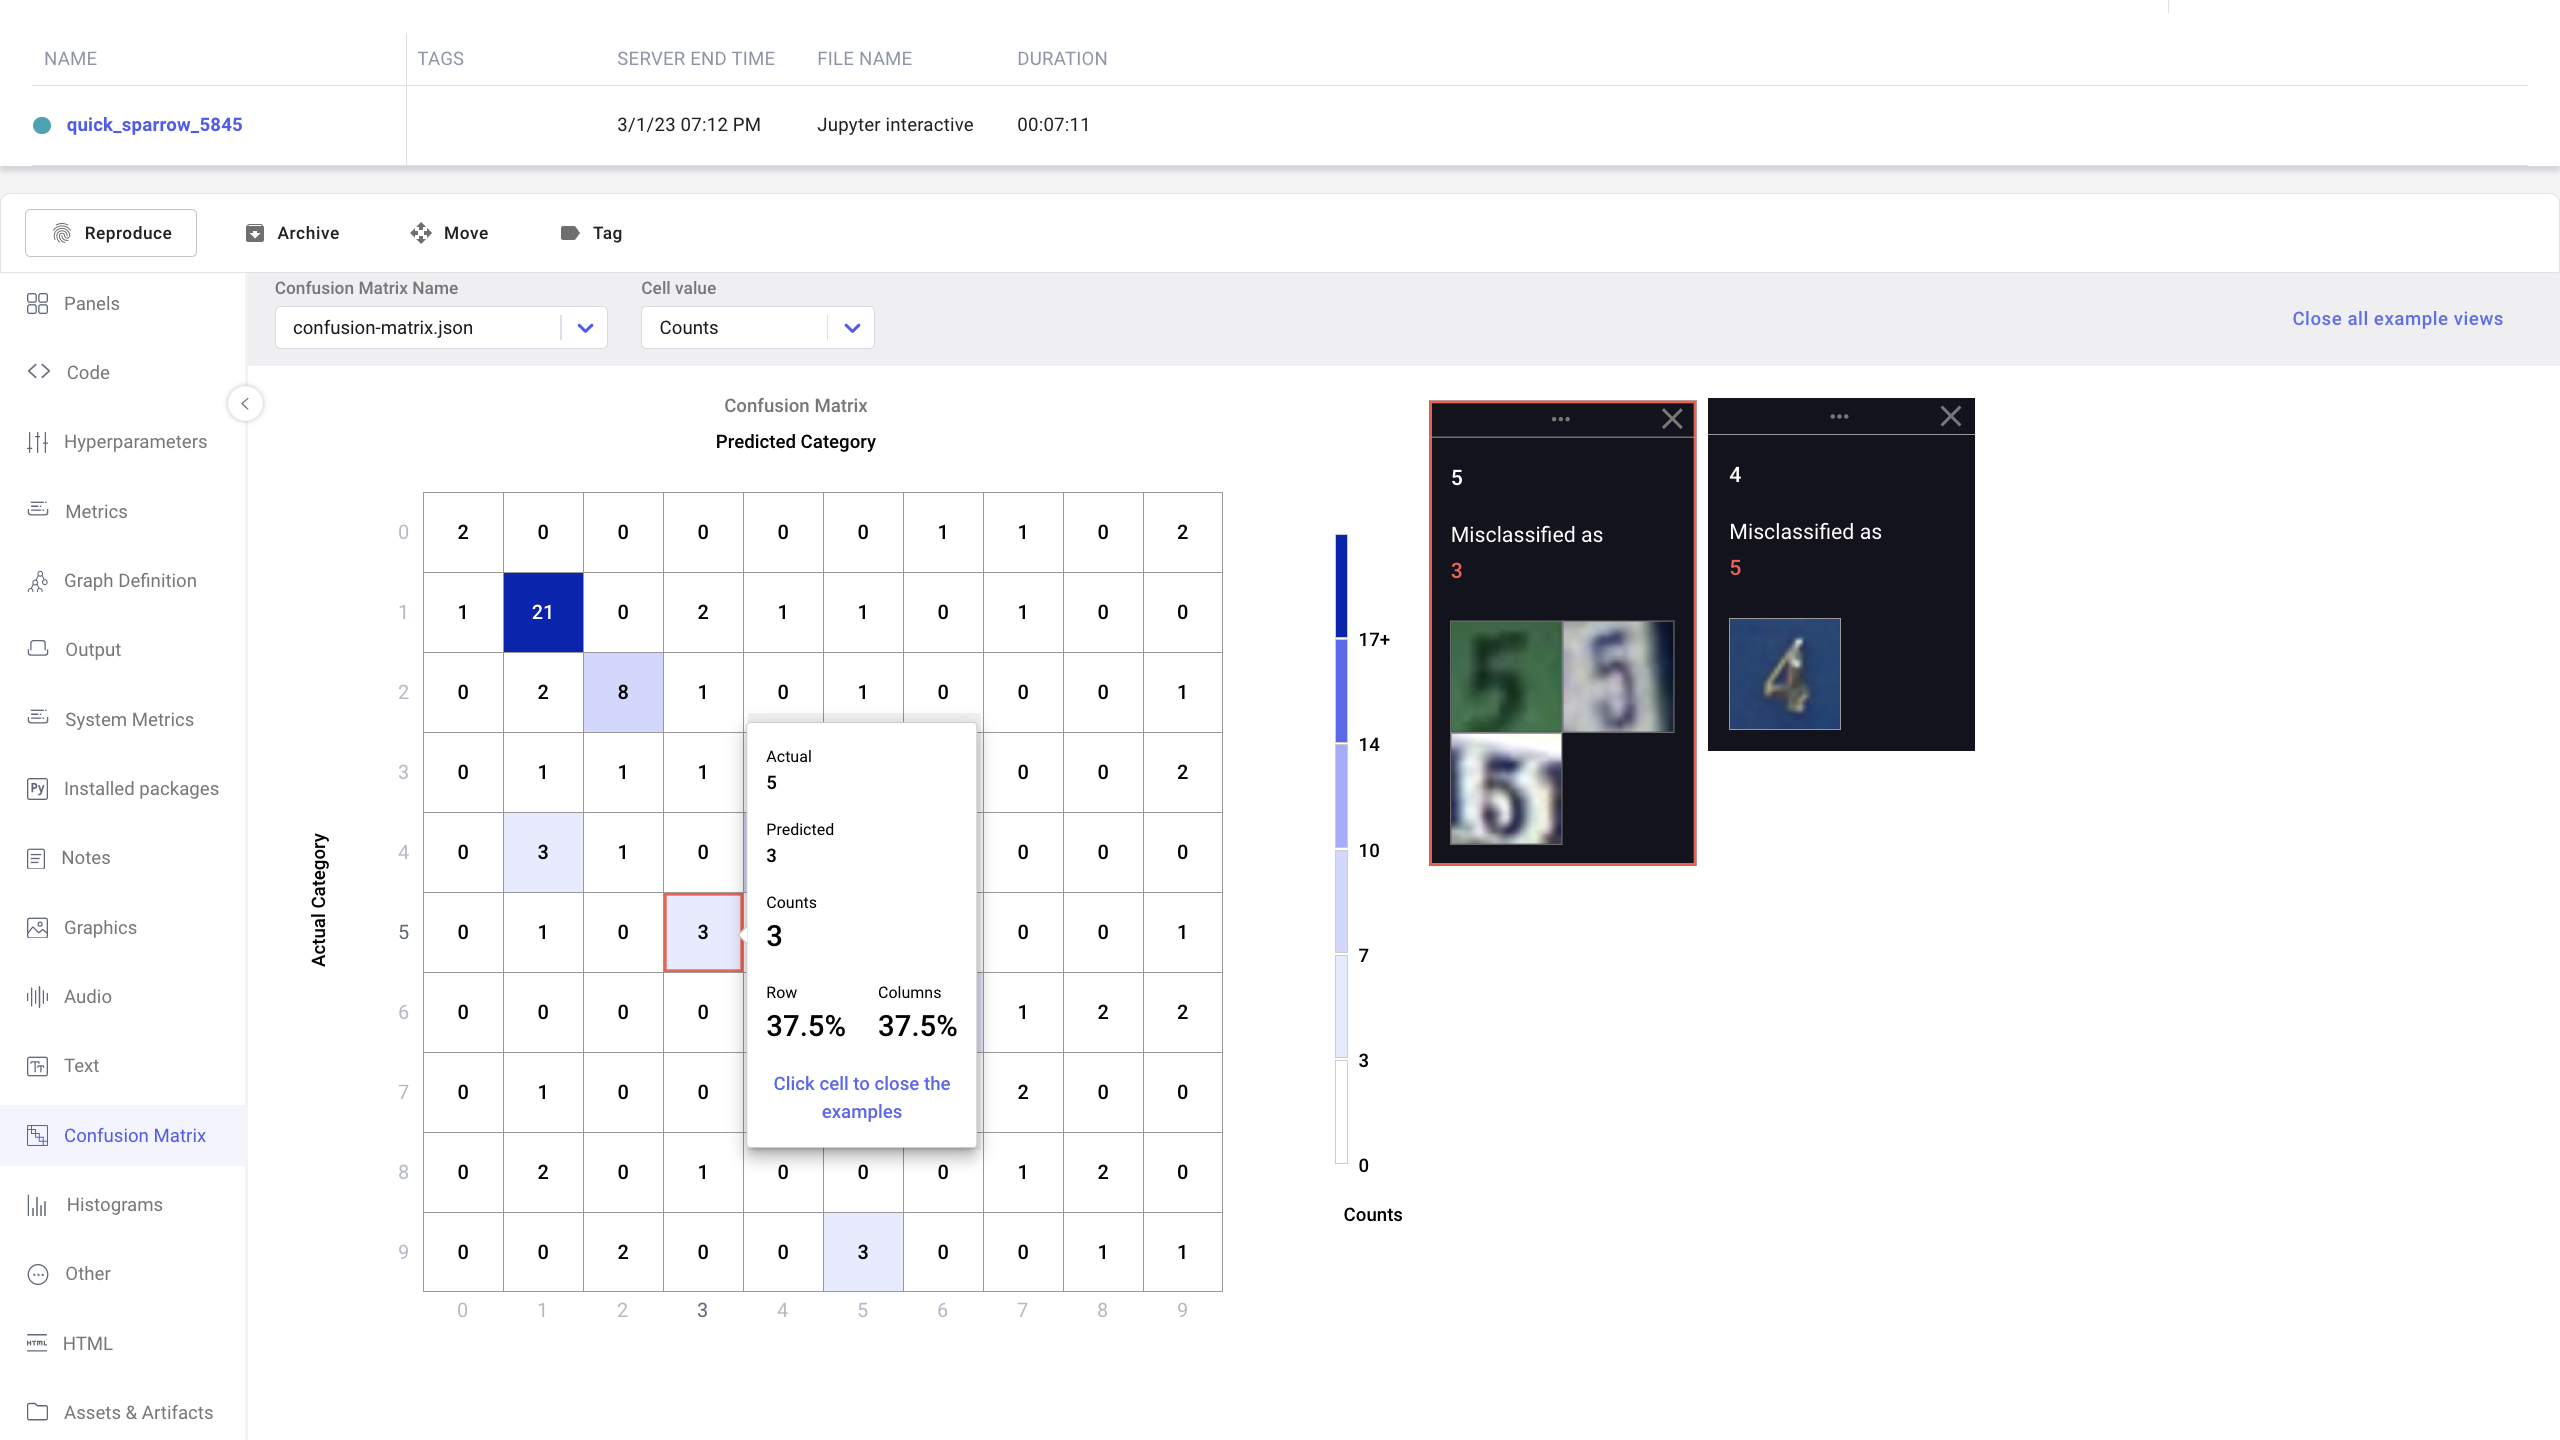

As you can see, the Confusion Matrix displays  misclassfied examples using the images that we logged earlier. 

Explore the Confusion Matrix below to see some of the misclssifications made by the model.

In [ ]:
# @title
from IPython.display import IFrame

IFrame(
    src="https://www.comet.com/team-comet-ml/pytorch-image-classification-svhn/7fd06a2fd0ae4c21953bbedca6c36a66?assetId=9647fa106b4c40f6aabb4d0796b5d5e7&experiment-tab=confusionMatrix",
    width=1000,
    height=500,
)

## 👩‍🔧 Using the Image Panel and Data Panel to find data issues

The Confusion Matrix is very useful at identifying misclassified examples, but how do we go about finding all the hard examples in our data?

You will recall that we logged a dataframe with information about the model predictions and the cross entropy loss associated with each example. 

We can use the Comet Data Panel to explore these dataframes and uncover high loss examples in our test dataset. High loss examples tend to have properties that make it difficult for the model to process.   

Once we've indentified these samples, we can visualize them with the Comet Image Panel  

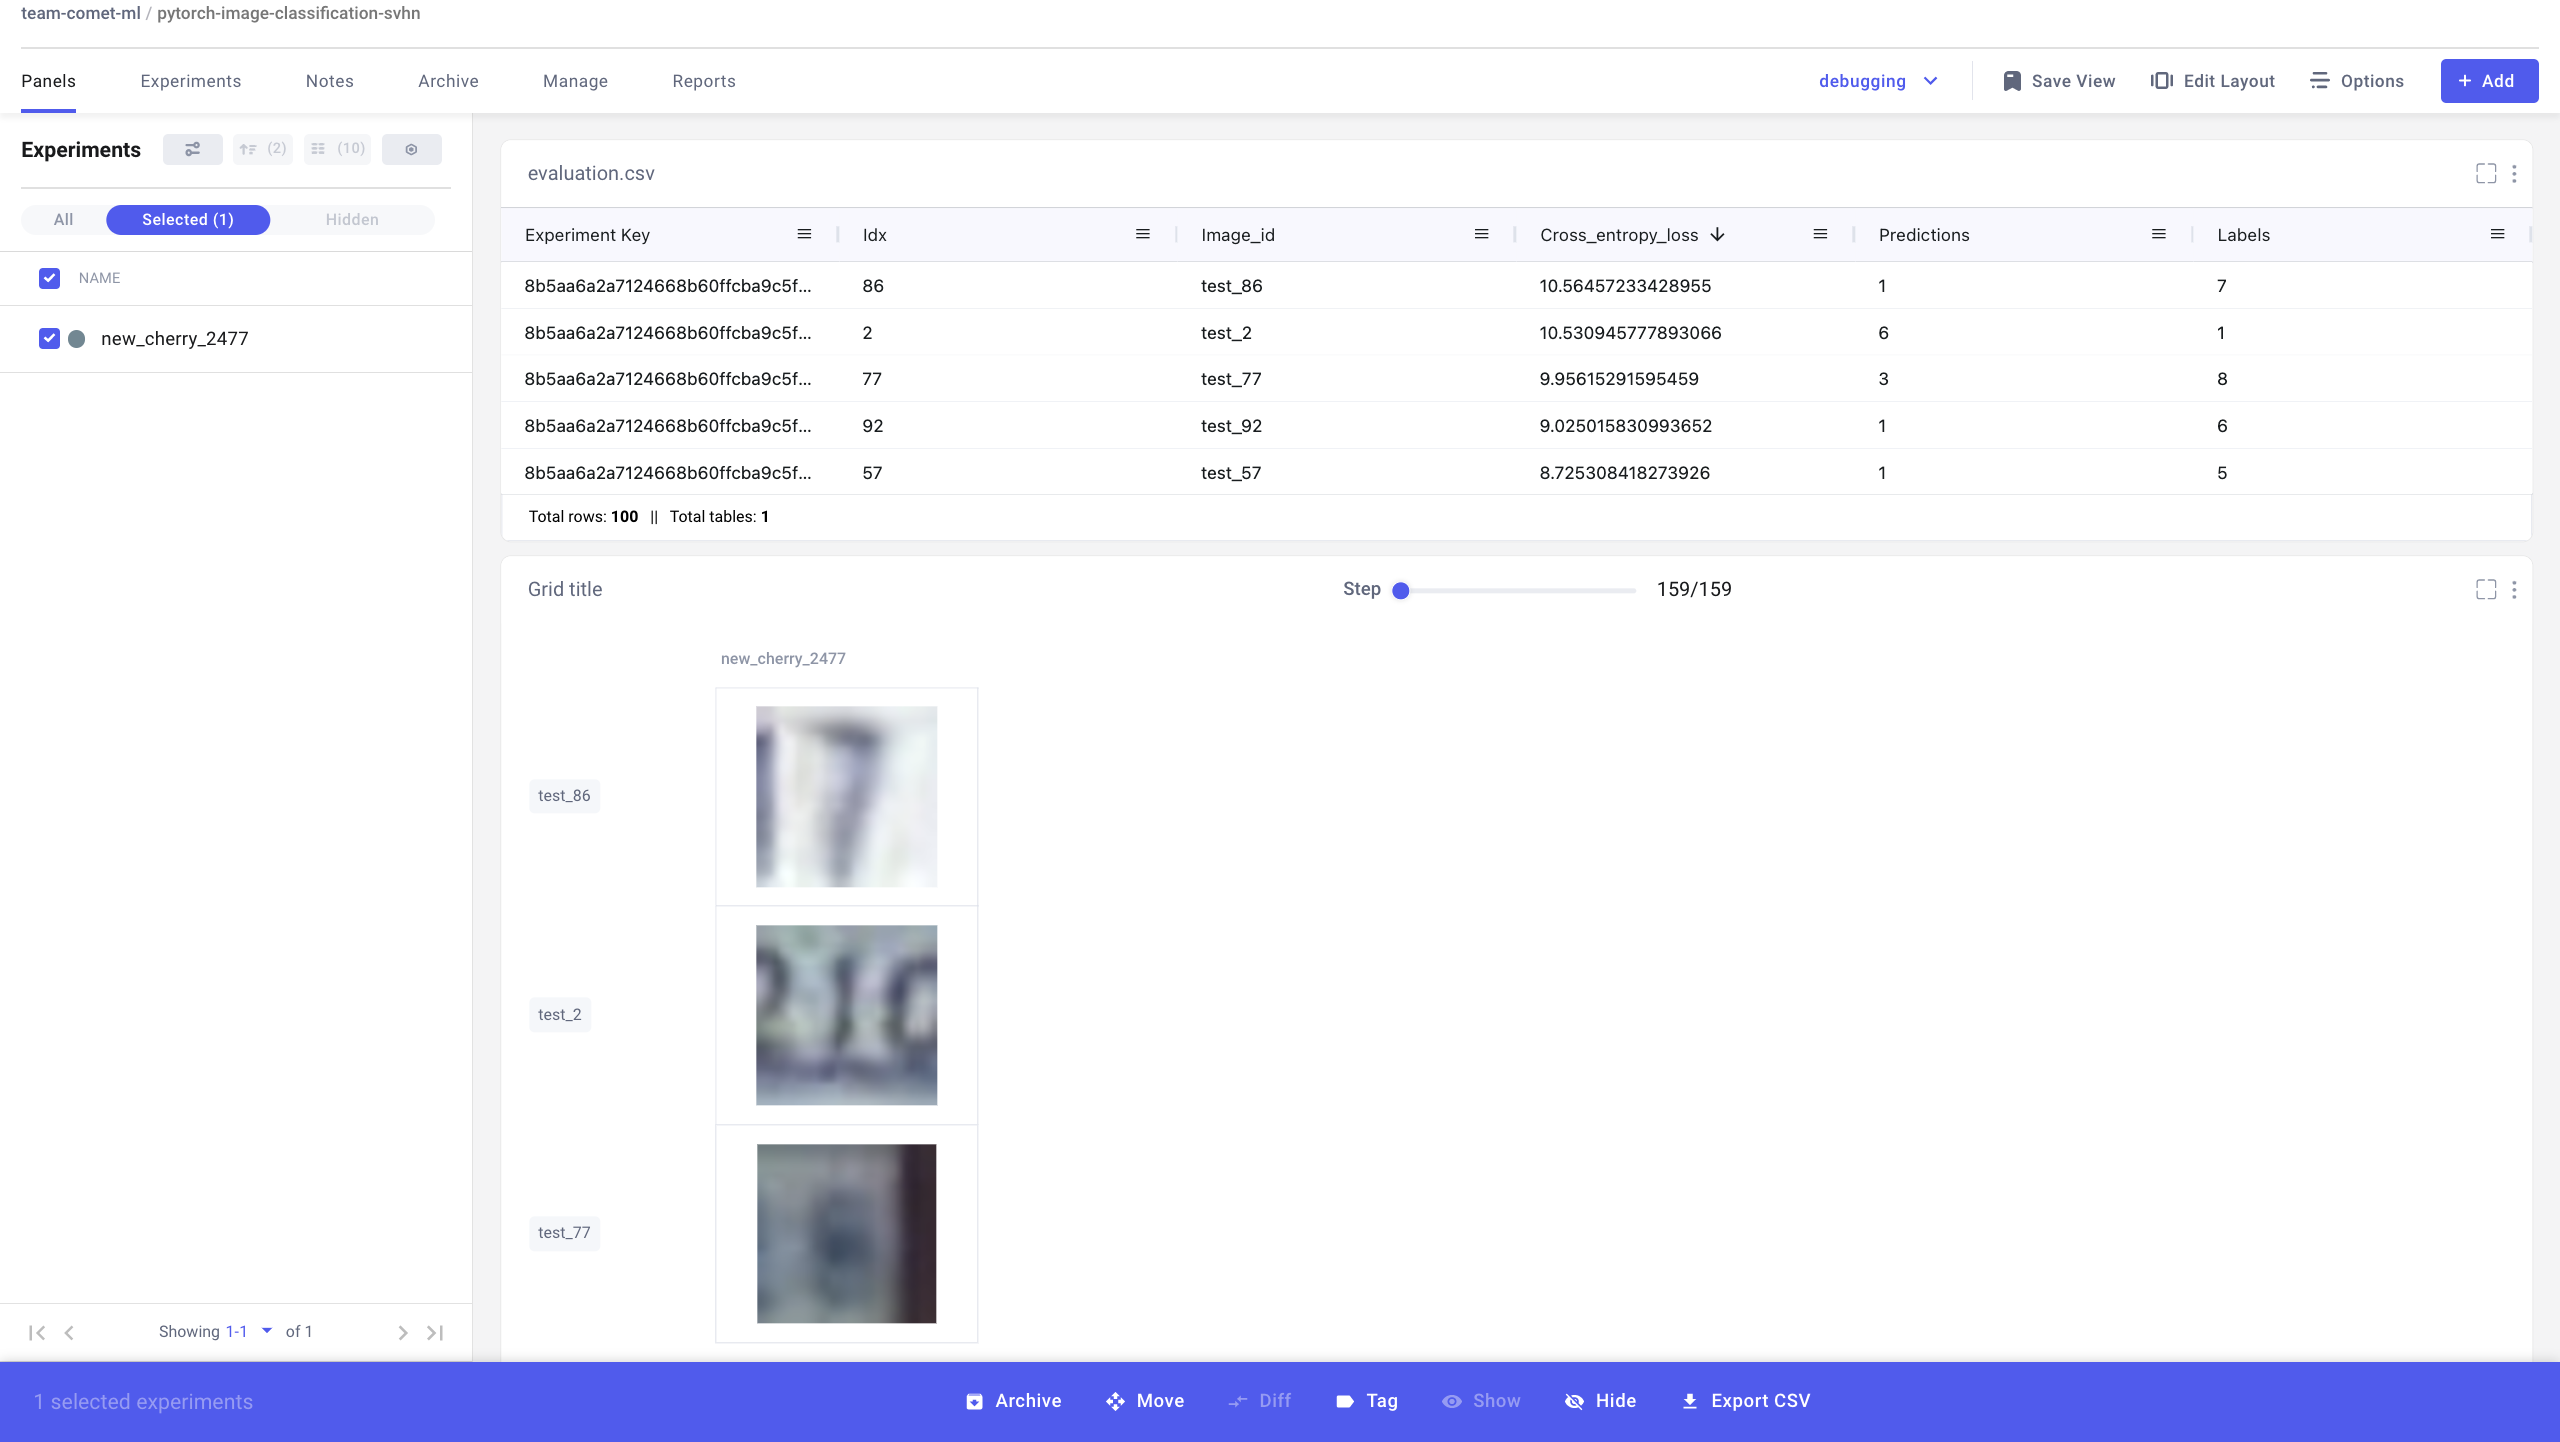

Based on our exploration with the Data Panel, we can see certain patterns in the difficult data. 

Images that are partially obscured or ones that have multiple digits within view tend to be difficult for the model to classify.  

# 🔭 Explore a Completed Project

If you would like to explore the results of this notebook yourself, head over to our project page to interact with the results of this experiment. 

[Link to Project](https://www.comet.com/team-comet-ml/pytorch-image-classification-svhn?shareable=KIwjYA7S5BWd0niZw3V0ywPlX?utm_source=website&utm_medium=referral&utm_campaign=Online_CV_2023&utm_content=colab-notebook)